<a href="https://colab.research.google.com/github/siddu49/Minor_Project/blob/main/PCA_ViT_IndianPines_(2)_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA + Vision Transformer (ViT) for Indian Pines

This notebook is Colab-ready and runs end-to-end: loading `.mat` files, PCA, patch extraction, building and training a Tiny-ViT, evaluation and plotting. **Run cells in order.**

**Note:** Upload `Indian_pines_corrected (2).mat` and `Indian_pines_gt (2).mat` into the Colab session (Files pane) before running.

In [1]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.io import loadmat
from pathlib import Path

OUTDIR = Path('pca_vit_prepared'); OUTDIR.mkdir(exist_ok=True)

params = {
    'pca_components': 3,
    'patch_size': 9,
    'num_classes': 16,
    'batch_size': 64,
    'epochs': 40,
    'lr': 1e-3,
    'vit_dim': 128,
    'vit_depth': 4,
    'vit_heads': 4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print('Using device:', params['device'])

Using device: cpu


## 1) Load Indian Pines `.mat` files
Upload the two `.mat` files to Colab (left Files pane) and run this cell.

In [2]:
cube = loadmat("Indian_pines_corrected (2).mat")["indian_pines_corrected"]
GT = loadmat("Indian_pines_gt (2).mat")["indian_pines_gt"]
H, W, C = cube.shape
print('Cube shape:', cube.shape, 'GT shape:', GT.shape)
print('Unique labels in GT (0 is unlabeled):', np.unique(GT))

Cube shape: (145, 145, 200) GT shape: (145, 145)
Unique labels in GT (0 is unlabeled): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## 2) PCA (reduce spectral bands to 3)

In [3]:
# Flatten, fit PCA, transform
cube_2d = cube.reshape(-1, C)
print('Flat shape for PCA:', cube_2d.shape)

pca = PCA(n_components=params['pca_components'], whiten=True, random_state=42)
cube_pca = pca.fit_transform(cube_2d)
cube_pca = cube_pca.reshape(H, W, params['pca_components'])
print('PCA result shape:', cube_pca.shape)
print('Explained variance ratio (sum):', pca.explained_variance_ratio_.sum())

Flat shape for PCA: (21025, 200)
PCA result shape: (145, 145, 3)
Explained variance ratio (sum): 0.9352152488891898


## 3) Extract 9×9 patches centered on labeled pixels and save `.npy` files

In [4]:
PATCH_SIZE = params['patch_size']
margin = PATCH_SIZE // 2
padded = np.pad(cube_pca, ((margin,margin),(margin,margin),(0,0)), mode='reflect')
patches = []
labels = []
for i in range(margin, H + margin):
    for j in range(margin, W + margin):
        lab = GT[i-margin, j-margin]
        if lab == 0:
            continue
        patch = padded[i-margin:i+margin+1, j-margin:j+margin+1, :]
        patches.append(patch)
        labels.append(int(lab-1))
patches = np.stack(patches).astype('float32')
labels = np.array(labels).astype('int64')
print('Extracted patches shape:', patches.shape)

train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.3, random_state=42, stratify=labels)
np.save(OUTDIR/'patches.npy', patches)
np.save(OUTDIR/'labels.npy', labels)
np.save(OUTDIR/'train_idx.npy', train_idx)
np.save(OUTDIR/'test_idx.npy', test_idx)
print('Saved preprocessed files to', OUTDIR)


Extracted patches shape: (10249, 9, 9, 3)
Saved preprocessed files to pca_vit_prepared


## 4) Dataset, DataLoader and quick forward-check

In [5]:
class HSIDataset(Dataset):
    def __init__(self, patches, labels, indices):
        self.x = patches[indices].astype('float32')
        self.y = labels[indices].astype('int64')
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        img = np.transpose(self.x[idx], (2,0,1)).copy()
        return torch.from_numpy(img), int(self.y[idx])

patches = np.load(OUTDIR/'patches.npy')
labels = np.load(OUTDIR/'labels.npy')
train_idx = np.load(OUTDIR/'train_idx.npy')
test_idx = np.load(OUTDIR/'test_idx.npy')

train_ds = HSIDataset(patches, labels, train_idx)
test_ds  = HSIDataset(patches, labels, test_idx)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

print('Train samples:', len(train_ds), 'Test samples:', len(test_ds))

# define model pieces for a quick forward check
class SimplePatchEmbedding(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim):
        super().__init__()
        self.proj = nn.Linear(in_ch * patch_size * patch_size, emb_dim)
    def forward(self, x):
        b = x.shape[0]
        x = x.reshape(b, -1)
        return self.proj(x)

class TinyViT(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim, depth, heads, num_classes):
        super().__init__()
        self.embed = SimplePatchEmbedding(in_ch, patch_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_dim))
        self.mlp_head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim,256), nn.GELU(), nn.Linear(256,num_classes))
    def forward(self, x):
        b = x.shape[0]
        patch_emb = self.embed(x).unsqueeze(1)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        tokens = torch.cat([cls_tokens, patch_emb], dim=1)
        out = self.transformer(tokens)
        cls_out = out[:,0,:]
        return self.mlp_head(cls_out)

model = TinyViT(params['pca_components'], params['patch_size'], params['vit_dim'], params['vit_depth'], params['vit_heads'], params['num_classes'])
xb, yb = next(iter(train_loader))
print('Batch shapes:', xb.shape, yb.shape)
print('Forward pass ->', model(xb.float()).shape)


Train samples: 7174 Test samples: 3075
Batch shapes: torch.Size([8, 3, 9, 9]) torch.Size([8])
Forward pass -> torch.Size([8, 16])


## 5) Training function and evaluate helper

In [6]:
def evaluate(model, loader, criterion, device):
    model.eval(); preds, trues = [], []; loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device).float(), yb.to(device)
            logits = model(xb); loss = criterion(logits, yb)
            loss_sum += float(loss) * xb.size(0)
            preds.append(logits.argmax(dim=1).cpu().numpy()); trues.append(yb.cpu().numpy())
    preds, trues = np.concatenate(preds), np.concatenate(trues)
    oa = (preds == trues).sum() / len(trues)
    cm = confusion_matrix(trues, preds)
    per_class_acc = np.array([cm[i,i]/(cm[i].sum()+1e-12) for i in range(params['num_classes'])])
    aa = per_class_acc.mean(); kappa = cohen_kappa_score(trues, preds)
    return {'loss': loss_sum/len(trues), 'oa': oa, 'aa': aa, 'kappa': kappa, 'cm': cm}

# Training hyperparams
device = torch.device(params['device'])
model = TinyViT(params['pca_components'], params['patch_size'], params['vit_dim'], params['vit_depth'], params['vit_heads'], params['num_classes']).to(device)
opt = torch.optim.Adam(model.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

history = {'train_loss': [], 'val_loss': [], 'val_oa': [], 'val_aa': [], 'val_kappa': []}
best_oa = 0.0

for epoch in range(1, params['epochs']+1):
    model.train(); running_loss=0.0; t0=time.time()
    for xb, yb in train_loader:
        xb, yb = xb.to(device).float(), yb.to(device)
        opt.zero_grad(); logits = model(xb); loss = criterion(logits, yb)
        loss.backward(); opt.step(); running_loss += float(loss)*xb.size(0)
    train_loss = running_loss/len(train_ds)
    val = evaluate(model, test_loader, criterion, device)
    history['train_loss'].append(train_loss); history['val_loss'].append(val['loss']); history['val_oa'].append(val['oa']); history['val_aa'].append(val['aa']); history['val_kappa'].append(val['kappa'])
    if val['oa'] > best_oa:
        best_oa = val['oa']
        torch.save({'model_state': model.state_dict(), 'opt_state': opt.state_dict(), 'epoch': epoch, 'oa': val['oa']}, OUTDIR/'checkpoint.pth')
    print(f"Epoch {epoch}/{params['epochs']} - train_loss={train_loss:.4f} val_loss={val['loss']:.4f} OA={val['oa']:.4f} AA={val['aa']:.4f} Kappa={val['kappa']:.4f} time={time.time()-t0:.1f}s")

np.save(OUTDIR/'train_history.npy', history)
torch.save(model.state_dict(), OUTDIR/'final_model.pth')
print('Saved final model and history to', OUTDIR)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-70846419.py:33: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss.backward(); opt.step(); running_loss += float(loss)*xb.size(0)


Epoch 1/40 - train_loss=1.3775 val_loss=1.1618 OA=0.5626 AA=0.4325 Kappa=0.4938 time=11.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/40 - train_loss=1.0741 val_loss=1.0542 OA=0.6078 AA=0.4822 Kappa=0.5422 time=11.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/40 - train_loss=1.0180 val_loss=0.9148 OA=0.6553 AA=0.4905 Kappa=0.5963 time=10.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/40 - train_loss=0.8521 val_loss=0.8396 OA=0.7031 AA=0.6168 Kappa=0.6641 time=12.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/40 - train_loss=0.8227 val_loss=0.7725 OA=0.7249 AA=0.5976 Kappa=0.6835 time=11.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/40 - train_loss=0.6963 val_loss=0.6316 OA=0.7668 AA=0.6597 Kappa=0.7339 time=12.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/40 - train_loss=0.6974 val_loss=0.6837 OA=0.7541 AA=0.6796 Kappa=0.7170 time=10.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/40 - train_loss=0.6570 val_loss=0.6124 OA=0.7720 AA=0.6724 Kappa=0.7390 time=11.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/40 - train_loss=0.5568 val_loss=0.5974 OA=0.7880 AA=0.6746 Kappa=0.7575 time=11.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/40 - train_loss=0.5810 val_loss=0.9087 OA=0.7015 AA=0.6375 Kappa=0.6624 time=11.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/40 - train_loss=0.5545 val_loss=0.4971 OA=0.8127 AA=0.7306 Kappa=0.7864 time=11.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/40 - train_loss=0.4025 val_loss=0.4595 OA=0.8481 AA=0.8039 Kappa=0.8262 time=12.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/40 - train_loss=0.3786 val_loss=0.8384 OA=0.7480 AA=0.7045 Kappa=0.7136 time=11.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/40 - train_loss=0.3669 val_loss=0.3390 OA=0.8745 AA=0.7768 Kappa=0.8568 time=11.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/40 - train_loss=0.2956 val_loss=0.3276 OA=0.8807 AA=0.8370 Kappa=0.8645 time=12.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/40 - train_loss=0.2806 val_loss=0.3307 OA=0.8829 AA=0.8886 Kappa=0.8663 time=11.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/40 - train_loss=0.3280 val_loss=0.3695 OA=0.8790 AA=0.8434 Kappa=0.8616 time=11.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/40 - train_loss=0.3525 val_loss=0.2378 OA=0.9161 AA=0.8836 Kappa=0.9042 time=11.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/40 - train_loss=0.2382 val_loss=0.3347 OA=0.8725 AA=0.8383 Kappa=0.8546 time=11.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/40 - train_loss=0.2715 val_loss=0.3209 OA=0.8943 AA=0.8570 Kappa=0.8791 time=11.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 21/40 - train_loss=0.2846 val_loss=0.2250 OA=0.9223 AA=0.9197 Kappa=0.9113 time=12.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 22/40 - train_loss=0.1657 val_loss=0.2133 OA=0.9320 AA=0.9324 Kappa=0.9224 time=12.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 23/40 - train_loss=0.2353 val_loss=0.2852 OA=0.8800 AA=0.8841 Kappa=0.8637 time=12.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 24/40 - train_loss=0.2254 val_loss=0.2102 OA=0.9327 AA=0.9074 Kappa=0.9231 time=12.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 25/40 - train_loss=0.1702 val_loss=0.1973 OA=0.9402 AA=0.9388 Kappa=0.9318 time=12.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 26/40 - train_loss=0.2070 val_loss=0.1912 OA=0.9350 AA=0.8570 Kappa=0.9258 time=12.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 27/40 - train_loss=0.1463 val_loss=0.2004 OA=0.9369 AA=0.9427 Kappa=0.9283 time=12.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 28/40 - train_loss=0.1595 val_loss=0.2675 OA=0.9281 AA=0.9408 Kappa=0.9183 time=12.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 29/40 - train_loss=0.1796 val_loss=0.2379 OA=0.9294 AA=0.8794 Kappa=0.9192 time=12.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 30/40 - train_loss=0.1476 val_loss=0.2310 OA=0.9314 AA=0.9297 Kappa=0.9218 time=12.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 31/40 - train_loss=0.1339 val_loss=0.1525 OA=0.9506 AA=0.9474 Kappa=0.9437 time=12.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 32/40 - train_loss=0.1779 val_loss=0.2723 OA=0.9154 AA=0.8548 Kappa=0.9035 time=12.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 33/40 - train_loss=0.2064 val_loss=0.2595 OA=0.9151 AA=0.8585 Kappa=0.9033 time=12.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 34/40 - train_loss=0.1661 val_loss=0.2981 OA=0.9015 AA=0.8603 Kappa=0.8879 time=12.6s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 35/40 - train_loss=0.2005 val_loss=0.1987 OA=0.9249 AA=0.9351 Kappa=0.9145 time=12.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 36/40 - train_loss=0.1262 val_loss=0.1436 OA=0.9528 AA=0.9404 Kappa=0.9463 time=12.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 37/40 - train_loss=0.1181 val_loss=0.1731 OA=0.9450 AA=0.9377 Kappa=0.9373 time=12.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 38/40 - train_loss=0.1184 val_loss=0.1749 OA=0.9447 AA=0.8917 Kappa=0.9370 time=12.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 39/40 - train_loss=0.0950 val_loss=0.1784 OA=0.9502 AA=0.9598 Kappa=0.9433 time=12.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 40/40 - train_loss=0.1257 val_loss=0.2875 OA=0.9021 AA=0.9311 Kappa=0.8891 time=12.9s
Saved final model and history to pca_vit_prepared


## 6) Plot training curves

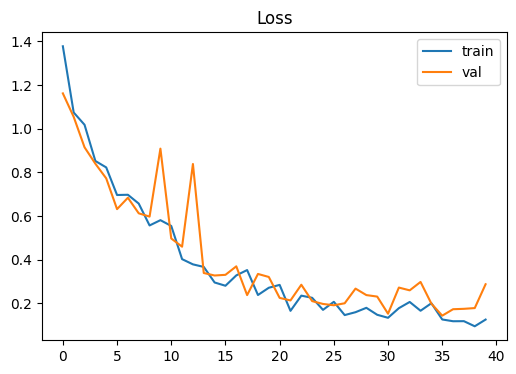

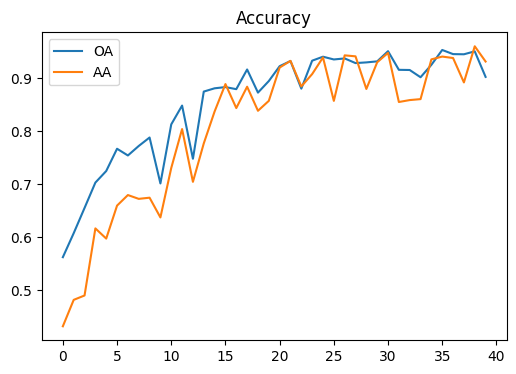

Plots saved to pca_vit_prepared


In [7]:
hist = np.load(OUTDIR/'train_history.npy', allow_pickle=True).item() if (OUTDIR/'train_history.npy').exists() else history
plt.figure(figsize=(6,4)); plt.plot(hist['train_loss'], label='train'); plt.plot(hist['val_loss'], label='val'); plt.legend(); plt.title('Loss'); plt.savefig(OUTDIR/'loss_plot.png'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist['val_oa'], label='OA'); plt.plot(hist['val_aa'], label='AA'); plt.legend(); plt.title('Accuracy'); plt.savefig(OUTDIR/'oa_plot.png'); plt.show()
print('Plots saved to', OUTDIR)


## 7) (Optional) Build full classification map and visualize
Run this cell to generate a 145×145 predicted map and compare against ground truth.

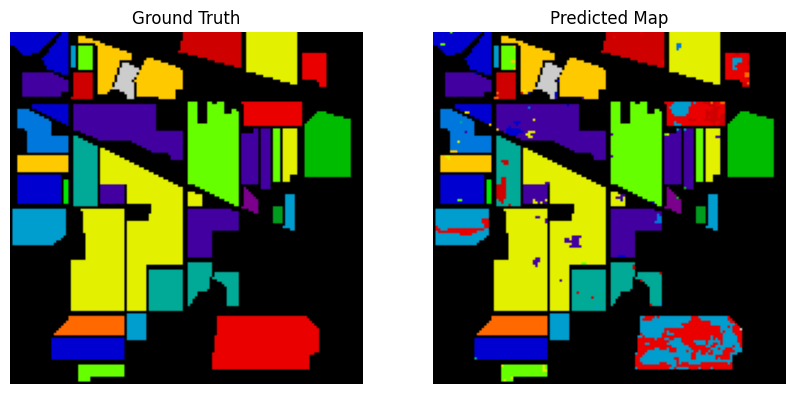

Saved classification map to pca_vit_prepared/classification_map.png


In [8]:
# Load trained model
model.load_state_dict(torch.load(OUTDIR/'final_model.pth', map_location=device))
model.to(device).eval()

# Recreate PCA on full cube (same as earlier)
pca = PCA(n_components=params['pca_components'], whiten=True, random_state=42)
cube_pca_full = pca.fit_transform(cube.reshape(-1, C)).reshape(H, W, params['pca_components'])

# pad
pad = params['patch_size']//2
cube_pad = np.pad(cube_pca_full, ((pad,pad),(pad,pad),(0,0)), mode='reflect')

pred_map = np.zeros((H, W), dtype=np.int32)
coords_list = []
patches_list = []
for i in range(H):
    for j in range(W):
        if GT[i,j] == 0: continue
        patch = cube_pad[i:i+params['patch_size'], j:j+params['patch_size'], :]
        patches_list.append(np.transpose(patch, (2,0,1)).astype('float32'))
        coords_list.append((i,j))

# batch predict
bs = 256
for s in range(0, len(patches_list), bs):
    batch = torch.from_numpy(np.stack(patches_list[s:s+bs])).to(device)
    with torch.no_grad():
        logits = model(batch)
        preds = logits.argmax(dim=1).cpu().numpy()
    for (i,j), p in zip(coords_list[s:s+bs], preds):
        pred_map[i,j] = p+1

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Ground Truth'); plt.imshow(GT, cmap='nipy_spectral'); plt.axis('off')
plt.subplot(1,2,2); plt.title('Predicted Map'); plt.imshow(pred_map, cmap='nipy_spectral'); plt.axis('off')
plt.savefig(OUTDIR/'classification_map.png', dpi=300); plt.show()
print('Saved classification map to', OUTDIR/'classification_map.png')
